### Liens python :

- [docs.python](https://docs.python.org)
- [python.doctor](https://python.doctor)

### Projet :
- [CVE dataset](https://nvd.nist.gov/vuln/data-feeds)

- [CVE descriptif](https://www.redhat.com/fr/topics/security/what-is-cve)

- [CPE descriptif](https://medium.com/prohacktive/comment-exploiter-la-base-cve-du-nist-dfb10837da5c)

- [Standards pour la gestion des vulnérabilités](https://www.cert-ist.com/public/fr/SO_detail?code=standards_gestion_vulnerabilites)

### à voir :

- cartopy
- ipywidget
- [kaggle](https://www.kaggle.com/)

### notes :

***CWE*** est un système de catégorisation des types de vulnérabilité, tandis que ***CVE*** est une référence à une vulnérabilité spécifique. 

files.maxMemoryForLargeFilesMB


<hr>

<h2>Introduction</h2>

**Common Vulnerabilities and Exposures** ou **CVE** est un dictionnaire des informations publiques relatives aux vulnérabilités de sécurité. Le dictionnaire est maintenu par l'organisme MITRE, soutenu par le département de la Sécurité intérieure des États-Unis.

**Common Vulnerability Scoring System** ou **CVSS** est un système d'évaluation standardisé de la criticité des vulnérabilités selon des critères objectifs et mesurables.


CVSS se compose de trois groupes de mesures : Base, Temporel, et Environnemental. 
Les métriques de base produisent un score allant de 0 à 10, qui peut ensuite être modifié en notant les métriques temporelles et environnementales.
<br>
Un score CVSS est également représenté sous la forme d'une chaîne vectorielle, une représentation textuelle comprimée des valeurs utilisées pour obtenir le score. Ainsi, CVSS est bien adapté comme système de mesure standard pour les industries, les organisations et les gouvernements qui ont besoin de scores de gravité de vulnérabilité précis et cohérents.
<br>

La base de données nationale sur les vulnérabilités (**NVD**) fournit des scores CVSS pour presque toutes les vulnérabilités connues.
<br>

**La NVD prend en charge les normes CVSS v2.0 et v3.X.**

![cvss](media/cvss.png)

Le NVD fournit des "scores de base" CVSS qui représentent les caractéristiques innées de chaque vulnérabilité.
Le NVD ne fournit pas actuellement de "scores temporels" (mesures qui évoluent dans le temps en raison d'événements extérieurs à la vulnérabilité) ou de "scores environnementaux" (scores personnalisés pour refléter l'impact de la vulnérabilité sur votre organisation). Cependant, le NVD fournit un calculateur CVSS pour CVSS v2 et v3 qui vous permet d'ajouter des données de score temporel et environnemental.
<br>

Pour certaines vulnérabilités, toutes les informations nécessaires à la création des scores CVSS peuvent ne pas être disponibles. Cela se produit généralement lorsqu'un fournisseur annonce une vulnérabilité mais refuse de fournir certains détails. Dans de telles situations, les analystes du NVD attribuent des scores CVSS en utilisant l'approche du pire cas. Ainsi, si un fournisseur ne fournit aucun détail sur une vulnérabilité, le NVD attribuera à cette vulnérabilité une note de 10.0 (la note la plus élevée).



In [ ]:
# For Download all cve dataset from nvd.nist.gov
# import requests
# from datetime import datetime

# url = 'https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{}.json.gz'

# for cve in range(2002, datetime.now().year+1):
#     data = requests.get(url.format(cve)).content
#     with open(f'cve_dataset/nvdcve-1.1-{cve}.json.gz','wb') as f:
#         f.write(data)

In [ ]:
import json
from glob import glob
import gzip
import pandas as pd
from pandas import json_normalize
import xml.etree.ElementTree as et
import IPython as IPy

pd.options.display.max_columns = None

In [ ]:
# Extract gzip data and create CVE dataframe
cve_dataset = []

for data in glob('cve_dataset/*20.json.gz'):
    with open(data,'rb') as f:
        json_data = json.loads(gzip.decompress(f.read()))

        cve_items = json_normalize(json_data['CVE_Items'])
        cve_items.drop(['cve.data_type','cve.data_format','cve.data_version','cve.references.reference_data','configurations.CVE_data_version','configurations.nodes','cve.description.description_data'],
            axis=1,
            inplace=True
        )

        # maybe todo with map & list comprehension
        descriptions = json_normalize(
            json_data['CVE_Items'],
            record_path=[['cve','description','description_data']],
            meta=[['cve','CVE_data_meta','ID']]
        )
        descriptions.drop(['lang'],axis=1,inplace=True)

        dataframe = cve_items.merge(descriptions,on='cve.CVE_data_meta.ID')

        dataframe.rename(
            columns={
                "cve.CVE_data_meta.ID":"ID",
                "cve.problemtype.problemtype_data":"cwe_ids",
                "cve.CVE_data_meta.ASSIGNER":"assigner",
                "value":"description"
            },
            inplace=True
        )

        dataframe = dataframe.set_index("ID")
        cve_dataset.append(dataframe)

CVE_df = pd.concat(cve_dataset)

CVE_df.insert(2, "cwe_names", None)

# Drop row where description = '** REJECT ** DO NOT USE THIS CANDIDATE NUMBER'
CVE_df.drop(CVE_df[CVE_df['description'].str.startswith('** REJECT **')].index, inplace=True)

CVE_df= CVE_df[sorted(CVE_df)]


In [ ]:
# extract CWE ids
CVE_df['cwe_ids'] = \
CVE_df['cwe_ids'].map(lambda x: [id['value'] for sublist in x for id in sublist['description']])


In [ ]:
# Use Common Weakness Enumeration (CWE) for CVE type categorisation
cwe_dataset = dict()
tree = et.parse('cve_dataset/cwec_v4.7.xml')
root = tree.getroot()

for weakness in root.iter('{http://cwe.mitre.org/cwe-6}Weakness'):
    cwe_dataset[weakness.get('ID')] = weakness.get('Name')

CWE_df = pd.DataFrame.from_dict(cwe_dataset, orient='index', columns=["CWE_NAME"])

In [ ]:
# mapping cwe_id with cwe_name
def categorise(row):
    cwe_names = []
    for id in row['cwe_ids']:
        try:
            cwe_names.append(CWE_df.loc[id.split("-",1)[1]]['CWE_NAME'])
        except:
            cwe_names.append(id)

    return cwe_names


CVE_df['cwe_names'] = CVE_df.apply(lambda row: categorise(row), axis=1)

In [ ]:
# need to use .astype(str) , because column cwe_ids and cwe_names are lists
# CVE_df.astype(str).duplicated(keep='last').sum()
CVE_df.astype(str).drop_duplicates(inplace=True)

## cast date
CVE_df['publishedDate'] = pd.to_datetime(CVE_df['publishedDate'])
CVE_df['lastModifiedDate'] = pd.to_datetime(CVE_df['lastModifiedDate'])

In [ ]:
# displays statistics for quantitative variables
CVE_df.describe()

In [ ]:
# find by CVE-id
# CVE_df.loc['CVE-2020-13283']

In [ ]:
# CVE_df.isnull().sum()

In [ ]:
# test graph
years = CVE_df['publishedDate'].dt.year

# years[years == 1989]
# a = years.value_counts().sort_index()

years.value_counts().sort_index().plot(kind='bar',figsize=(15, 5),logy=True)


In [ ]:
import matplotlib.pyplot as plt
# Dealing with List Values in Pandas Dataframes
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

# cve_published_2020 = CVE_df[CVE_df['publishedDate'].dt.year == 2020]

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

cwe_ids = to_1D(CVE_df['cwe_ids']).value_counts()


fig, ax = plt.subplots(figsize = (14,4))

ax.bar(cwe_ids[1:6].index, cwe_ids[1:6].values)

ax.set_ylabel("Number", size = 12)

ax.set_title("CWE in 2020", size = 14)


interactive(children=(IntSlider(value=2020, description='Years :', max=2022, min=2002), Output()), _dom_classe…

<function __main__.years_changed(year)>

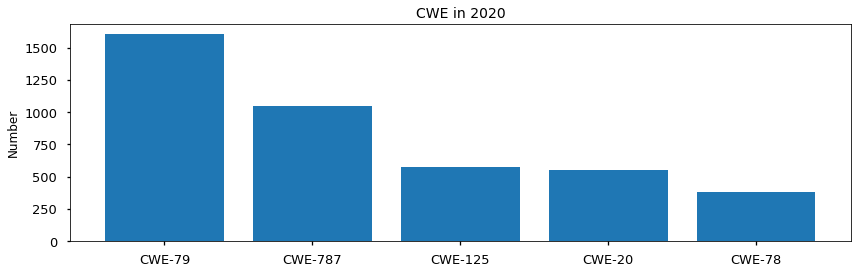

In [39]:
import ipywidgets as ipw


years_slider = ipw.IntSlider(value=2020, min=2002, max=2022, step=1, description='Years :')

def years_changed(year):
    
    cve_in_year =  CVE_df[CVE_df['publishedDate'].dt.year == year]

    cwe_ids = to_1D(cve_in_year['cwe_ids']).value_counts()

    fig, ax = plt.subplots(figsize = (14,4))

    ax.bar(cwe_ids[1:6].index, cwe_ids[1:6].values)

    ax.set_ylabel("Number", size = 12)

    ax.set_title(f"CWE in {year}", size = 14)

    # ax.bar_label("ttt")


ipw.interact(years_changed, year = years_slider)

